# 7. Scrapping feedback from indeed
-------------------
Group 3 , October 11, 2022
1. Gezhi Cheng, 
2. Haowei Lee, 
3. Ziyi Liu, 
4. VS Chaitanya Madduri

> <i>Description: In this notebook, analysis is carried on employee reviews of Charah solutions company.</i>


<div class="alert alert-block alert-info">
    <b>FYI:</b> #Please run the code in the local machine.
</div> 

### Pre requisites: 
1. Please install Python selenium package.

 `pip install selenium`
2. Install the chromedriver to run the selenium in your machine. Please download the chrome driver that is compatible with the chrome version you are using. url - [https://chromedriver.chromium.org/downloads](https://chromedriver.chromium.org/downloads)
 
3. Please place the chrome driver in the `C:\Program Files\`. In case you want it to be placed in another path please change the driver path on the cell 4.

Files:

### Output files:
1. reviews.csv - file contains all the charah's reviews with description, rating and date of entry.





## 1. Import Required Packages 

In [1]:
import time
import pandas as pd
import pickle
import re
import nltk                                               # For text preprocessing we use nltk  
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

nltk.download('stopwords')


from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


from nltk.corpus import stopwords                         # Removing all the stopwords
from nltk.stem.porter import PorterStemmer                # Reducing words to base form


%matplotlib inline

In [ ]:
# to make plotly graphs stay in the notebook
import plotly.io as pio
pio.renderers.default = 'iframe'

## 2. Scraping the reviews from indeed

In [3]:
# Hardcoded the review urls in a list. On 11/10/2022 there where 96 reviews intotal/

links = ['https://www.indeed.com/cmp/Charah-Solutions,-Inc/reviews',
'https://www.indeed.com/cmp/Charah-Solutions,-Inc/reviews?start=40',
'https://www.indeed.com/cmp/Charah-Solutions,-Inc/reviews?start=20',
'https://www.indeed.com/cmp/Charah-Solutions,-Inc/reviews?start=60',
'https://www.indeed.com/cmp/Charah-Solutions,-Inc/reviews?start=80']

In [4]:
# creating empty list for capturing the scrape data
main_heading_data=[]
main_description = []
pro_data=[]
con_data=[]
rating = [] 
date = []
for link in links:
    with Chrome(executable_path=r'C:\Program Files\chromedriver.exe') as driver:
            wait = WebDriverWait(driver,15)
            driver.get(link)
            time.sleep(5)
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//span[contains(@class,'css')]/ancestor::*[contains(@data-tn-element,'individualReviewLink')]"))):
                main_heading_data.append(comment.text)
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//span[contains(@class,'css')]/ancestor::*[contains(@data-tn-component,'reviewDescription')]"))):
                main_description.append(comment.text)
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//*[contains(text(),'Pros')]/following-sibling::div/child::*/child::*"))):
                pro_data.append(comment.text)
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//*[contains(text(),'Cons')]/following-sibling::div/child::*/child::*"))):
                con_data.append(comment.text)                  
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//button[contains(@aria-label,'stars')]//ancestor::*[contains(@itemprop,'reviewRating')]"))):
                rating.append(comment.text)
            for comment in wait.until(EC.presence_of_all_elements_located((By.XPATH, "//*[contains(@rel,'nofollow')]//ancestor::*[contains(@data-tn-entitytype, 'reviewId')]"))):
                date.append(comment.text)
                
                

C:\Users\chait\AppData\Local\Temp/ipykernel_21276/669221913.py:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  with Chrome(executable_path=r'C:\Program Files\chromedriver.exe') as driver:


In [5]:
# displaying all the main headings in the page
main_heading_data

['Pay was decent.',
 'Steady place to work; great training.',
 "It's work",
 'Great atmosphere',
 'Would give zero stars if I could',
 "It's Work",
 'Sucks',
 'Awesome',
 'Best place I’ve ever worked at.',
 'Worst place I’ve ever worked',
 'Don’t waste your time.',
 'Long days / short days',
 'The opportunity to expand your education. The company come together and discuss issues.',
 'No management no safety',
 'Poor management',
 'Straight to the point',
 'Stay away from this place run',
 'The good always over rides the bad with Charah Solutions',
 'Bad management poor work policy',
 'Hiring position not accurate',
 'Good hours safety comes first',
 'Pay was decent.',
 'Horrible',
 'Horrible Organization to Work For',
 "Not a bad place to work for 1 month. Then it's all down hill.",
 'productive',
 'Applied for haul truck driver..Was lied to about position...run the other direction !!!',
 'Charah',
 'Bad with buddy system',
 'Clueless company with a culture of yes men and brown nosers'

In [6]:

len(main_description)

100

In [7]:
len(rating)

100

In [8]:
len(date)

100

In [43]:
len(main_description)

16

### 2.1 Placing the data in a dictionary

In [9]:
columns = ['main_heading','description','rating','date']
master_dataframe = pd.DataFrame(columns= columns)

In [10]:
master_dataframe['main_heading'] = main_heading_data
master_dataframe['description'] = main_description
master_dataframe['rating'] = rating
master_dataframe['date'] = date


In [11]:
# droping duplicates
master_dataframe.drop_duplicates(inplace=True)

In [195]:
master_dataframe['date'][0]

'3.0\nPay was decent.\nTruck Driver (Former Employee) - Wilmington, NC - September 12, 2022\nIndeed Featured review\nThe most useful review selected by Indeed\nLong hours, equipment had no am fm radios, or fuses were removed. Very long hours. At least you got a 30min lunch ant two breaks, one in morning and one in the afternoon.\nPros\nYou could make money.\nCons\nLong hours, no radio in equipment\nWas this review helpful?\nYes\nNo\nReport\nShare'

In [45]:
# extracting the year of entry from the date. You can find the date  
master_dataframe['year'] = master_dataframe['date'].str.split(" - ").str[2].str.split("\n").str[0].str.split(",").str[1].str.strip()

In [46]:
# saving the reviews in a csv file
master_dataframe.to_csv("reviews.csv", index=None)

In [47]:
# type casting rating column
master_dataframe.rating = master_dataframe.rating.astype('float')

In [48]:
# Average rating value 
master_dataframe.rating.mean()

3.0625

## 3. Analysis on pros and cons

Point to be onbserved is not every review has pros and cons. we we have collected which every possible.

In [49]:
# printing the number of the con messages
len(con_data)

37

In [50]:
# printing the number of the pros messages
len(pro_data)

38

In [51]:
con_data

['Slow career advancement',
 'Long hours and one short break',
 'Everything else',
 'Long hours, no radio in equipment',
 'You have to be a committed tem player.',
 'time away from home',
 'Poor management! People are no good to work with.',
 'Working away from home with only 1 day home every week or 2 weeks.',
 "Don't care about help treat u like dogs",
 'bad managment',
 'long hours 60 plus, poor leadership, revolving doors with managers lasting only a few months, bad internal politics',
 'I couldn’t find any',
 'real dangerous anything could happen any minute',
 'Managers',
 'They don’t pay accurate overtime, no personal time, no sick pay, they use PTO to cover your hours for making you take time off when plant goes down, this years raise was 1% 0.21 cents.',
 'Management',
 'job ending',
 'Travel',
 'low start pay',
 'HR unreliable - upper mgmt. not hands on',
 'Racist Employees',
 'No breaks. Long hours. Work weekends.',
 'Traveling most of the time',
 'Terrible mangement and job 

### 3.1 Cleaning the Cons messages

In [52]:
# we can see there are some unwanted entries in the list example entry which has all the buttons names of the website 
# we will remove them from the list 

In [53]:
con_data = [sentence for sentence in con_data if 'Hiring Lab' not in sentence]

In [54]:
# removing the duplicates from the list
con_data = list(set(con_data))

In [55]:
pro_data[:30]

['Good pying job',
 'Benefits and pay',
 'good communication',
 'Per diem paid for working away from home. Will often give free breakfast/lunches, great benefits.',
 'Decent starting pay',
 'low tech material handling-easy',
 'good hours',
 'They buy lunch often',
 'Money',
 'Good atmosphere, coworkers',
 'na',
 'Always work',
 'People',
 'Pay, Hours',
 'Always new challenges to improve working conditions.',
 "It's a job",
 'Good co workers',
 'Pay',
 'Good Pay',
 'Decent Salary',
 'Benefits',
 'Work schedule',
 'Learning, people, environment',
 'Quitting time',
 'Health care',
 'None',
 'good over time and leaned new things',
 'You could make money.',
 'Work ethic surpassed anything that is known today.',
 'No accountability']

### 3.2 Cleaning the pros messages

In [56]:
pro_data = [sentence for sentence in pro_data if 'Hiring Lab' not in sentence]

In [57]:
# removing the duplicates from the list
pro_data = list(set(pro_data))

### 3.3 Saving the words list in pickle files

In [23]:
with open('pro_sentenses.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(pro_data, f) 

In [24]:
with open('con_sentenses.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(con_data, f) 

## 4. Data Analysis

In [59]:

def data_clean(input_text):
    '''
    The function will do the following:
    1. Extract only the Aplhas numerical strings 
    2. Apply porter stemming which will convert a word to its root form . 
        for example : hidden will be converted to hide
    3. removes words less than 3 letters (making sure to avoid residual strings)
    Augments:
    input_text: the text to be stemmed
    
    return :
    test_process/input_text : cleaned text if there are any errors it will return the orginal text
    '''
    ps = PorterStemmer()
    try:
        test_process = re.sub('[^a-zA-Z0-9]', ' ', input_text)         # Removing special symbols like ... ! and keeping only text
        test_process = test_process.lower()                                     # Lower case
        test_process = test_process.split()                                     # string split into words
        test_process = [ps.stem(word) for word in test_process                  # reducing words to base form
              if (not word in set(stopwords.words('english')) ) and len(word)>3  ]
        test_process = " ".join(test_process)
        return test_process
    except:
        return input_text


### 4.1 Word cloud analysis on the Pro words

In [60]:
pro_data_cleaned = [data_clean(sentence) for sentence in pro_data]

In [61]:

word_string=" ".join(pro_data)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=20
                         ).generate(word_string)

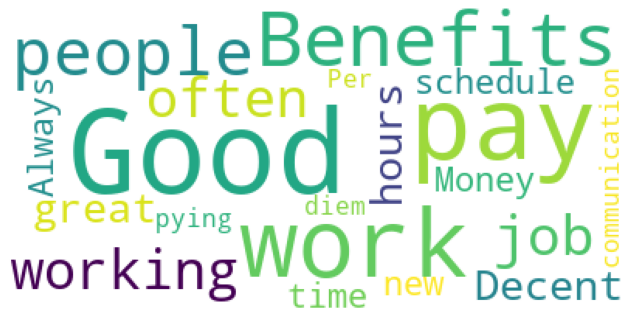

In [62]:
plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### 4.2 Word cloud analysis on the con words

In [63]:

word_string=" ".join(con_data)
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=20
                         ).generate(word_string)

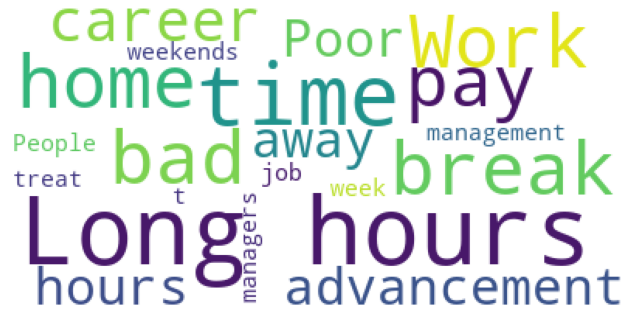

In [64]:
plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# get the most postive and negative words 

### 4.3 Sentiment analysis using the VEDAR <a class="anchor" id="chapter7.4"></a>

Refer : https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/

Note :
 - The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1 (most extreme negative) and +1 (most extreme positive).
 - positive sentiment : (compound score >= 0.05) 
 - neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
 - negative sentiment : (compound score <= -0.05)

In [65]:
# import SentimentIntensityAnalyzer class
# from vaderSentiment.vaderSentiment module.

# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)

 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return "Negative"
 
    else :
        return "Neutral"
 
 

In [210]:
# vedar sentiment vs rating
master_dataframe[['rating','vedar_sentiment']].value_counts()

rating  vedar_sentiment
5.0     Positive           22
4.0     Positive           18
1.0     Positive           12
3.0     Positive           12
1.0     Negative           11
2.0     Positive            6
1.0     Neutral             4
2.0     Negative            3
4.0     Negative            2
        Neutral             2
2.0     Neutral             1
3.0     Neutral             1
5.0     Negative            1
        Neutral             1
dtype: int64

- Note: a positive sentiment means employee like working for the company and negative means doesn't. Obiviously neutral when the employee stands in the middle ground

In [ ]:
As you can see vedar is not extactly extarcting the 

In [66]:
master_dataframe.head(2)

,main_heading,description,rating,date,year
0,Pay was decent.,"Long hours, equipment had no am fm radios, or ...",3.0,3.0\nPay was decent.\nTruck Driver (Former Emp...,2022
1,Steady place to work; great training.,I enjoyed my time at Charah. I was treated as ...,5.0,5.0\nSteady place to work; great training.\nJo...,2022


In [67]:

master_dataframe['description_cleaned'] = master_dataframe['description'].apply(lambda x: data_clean(x) )

In [68]:
master_dataframe['vedar_sentiment'] = master_dataframe['description_cleaned'].apply(lambda x: sentiment_scores(x) )

In [204]:
fig = px.pie(master_dataframe, names='vedar_sentiment')
fig.show()

### 4.3 Sentiment based on the rating provided

In [80]:
# function to print sentiments
# of the sentence based on teh rating.
def sentiment_scores_rating(rating):
    
 
    # decide sentiment as positive, negative and neutral
    if rating >= 3.5 :
        return "Positive"
 
    elif rating <= 2  :
        return "Negative"
 
    else :
        return "Neutral"
 
 

In [81]:
master_dataframe['sentiment_scores_rating'] = master_dataframe['rating'].apply(lambda x: sentiment_scores_rating(x) )

In [205]:
fig = px.pie(master_dataframe, names='sentiment_scores_rating')
fig.show()

In [134]:
# Rating to year matrix
master_dataframe.groupby(['sentiment_scores_rating','year']).size().unstack(fill_value=0).reset_index().set_index('sentiment_scores_rating')

year,2013,2015,2016,2017,2018,2019,2020,2021,2022
sentiment_scores_rating,,,,,,,,,
Negative,1,0,1,7,5,12,3,4,4
Neutral,1,1,0,3,2,4,0,1,1
Positive,0,0,2,10,11,9,2,6,6


In [145]:
temp_df = master_dataframe.groupby(['year','sentiment_scores_rating']).size().unstack(fill_value=0).reset_index()

In [165]:
# filtering out the reviews from 2018 as the company started financial filling from
temp_df['year'] = temp_df['year'].astype(int)
temp_df[temp_df['year']>2018]

sentiment_scores_rating,year,Negative,Neutral,Positive
5,2019,12,4,9
6,2020,3,0,2
7,2021,4,1,6
8,2022,4,1,6


In [180]:
temp_df[temp_df['year']>=2018].to_csv("Sentiment_Disturbution.csv", index=None)

In [207]:


fig = px.bar(temp_df[temp_df['year']>=2018], x="year", y=['Negative', 'Neutral', 'Positive'],
             title="Yearly Sentiment Disturbution",
# text=['Negative', 'Neutral', 'Positive'],
             color_discrete_sequence=[
                                    "#7c98b3",
                                    '#accbe1',                                    
                                    "#cee5f2"
                                    ])
# fig.for_each_trace(lambda t: t.update(texttemplate = t.texttemplate + ' %'))
fig.show()

In [146]:
temp_df.head()

sentiment_scores_rating,year,Negative,Neutral,Positive
0,2013,1,1,0
1,2015,0,1,0
2,2016,1,0,2
3,2017,7,3,10
4,2018,5,2,11


In [209]:
master_dataframe.head(2)

,main_heading,description,rating,date,year,description_cleaned,vedar_sentiment,sentiment_scores_rating,count
0,Pay was decent.,"Long hours, equipment had no am fm radios, or ...",3.0,3.0\nPay was decent.\nTruck Driver (Former Emp...,2022,long hour equip radio fuse remov long hour lea...,Neutral,Neutral,1
1,Steady place to work; great training.,I enjoyed my time at Charah. I was treated as ...,5.0,5.0\nSteady place to work; great training.\nJo...,2022,enjoy time charah treat part organ reward perf...,Positive,Positive,1


### 4.4 overall world cloud

In [99]:

word_string=" ".join(master_dataframe['description'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=20
                         ).generate(word_string)

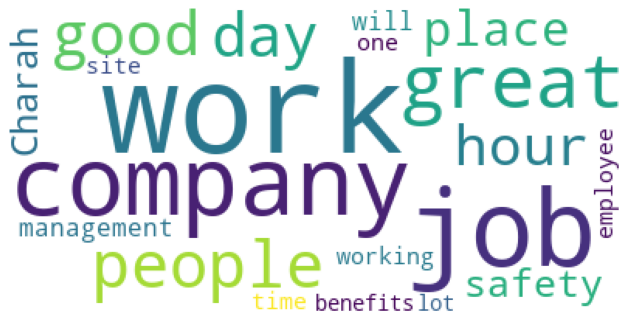

In [101]:
plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("word_cloud.png")
plt.show()

### End of the Notebook